# BE/Bi 103, Fall 2016: Homework 7
## Due 1pm, Sunday, November 13

(c) 2016 Justin Bois and Heidi Klumpe. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw7.ipynb). You can also view it [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/homework/hw7.ipynb).*

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba

import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2}
sns.set(rc=rc)
%matplotlib inline

### Problem 7.1: Practice writing posteriors (25 points + 10 points extra credit)

This problem is a worth a total of 25 points. You can do any subset of these problems to get full (or full plus extra) credit.

**a)** (10 pts) Write and/or draw a flow chart the details the steps from "Write Bayes' Theorem" to arriving at the final form of the posterior for a parameter estimation problem. If you hand-sketch the flow chart, you can include it in your Jupyter notebook as a scan. To include an image with Markdown, so this:

    ![description of image](file_of_image.png)
    
Be sure to include the image itself in your repository.

**b)** The Elowitz lab is interested in the design principles of cellular signaling pathway architectures, or how the interactions between signaling pathway components (things like extracellular ligands and receptors) give rise to different signal processing capabilities. Below are some experiments we might run to get a better quantitative understanding of cell signaling. 

For each of the following scenarios:
* (3 pts) Write the full form of the likelihood and prior you would use to estimate the parameter(s). *You must define all symbols (e.g. parameters and variables).*
* (2 pts) Explain why you chose the form you did, including what you chose to neglect or exclude. More than one version may be appropriate, so give convincing reasons to select the form you wrote.

**Exercise 1:**
You have images of many fields of cells, where fluorescently-labeled receptors at the cell surface appear as dots. (Assume these are maximum projections of confocal images, so that the image includes the entire cell membrane). You would like to estimate the mean number of receptors expressed by this cell line, and are using an automated image analysis tool that can count the number of dots on each cell. A previous paper reported that there are are $10^6 \pm 10^3$ of this receptor type expressed by this cell line.

**Exercise 2:**
You decide to get higher throughput counts by flowing your fluorescently-labeled cells. However, first you need to know how the fluorescence depends on the number of fluorophores, which we presume to be equal to the number of receptors. To start approximating this, you measure the fluorescence of beads ($F$) with a known number of fluorophores attached to each ($N$). You assume the fluorescence depends linearly on the number of fluorophores, and that there is some background fluorescence: 

\begin{align}
F(N \mid a, b) = aN + b.
\end{align}

We are interested in estimating the values of $a$ and $b$ (though we recognize the background fluorescence will probably be different in our cells).

**Exercise 3:**
A fully-formed signaling complex requires two receptor subunits, and sometimes these receptors come together spontaneously. You want to estimate the average rate at which this happens. You put one half of a fluorescent protein on one receptor subunit and the other half on the other receptor subunit. If the subunits spontaneously come together, you will observe a fluorescent dot. You use time-lapse microscopy to image these cells, and generate a list of the times between dots on given single cells (e.g. you waited $t_1$, $t_2$, etc. seconds between seeing receptors spontaneously come together on cell $j$).

**Exercise 4:**
You weren't able to do the experiment described in **Exercise 3**, but you read about it in a paper and request the data. They send you a table that reports the number of times receptor complexes spontaneously formed in ten minute intervals for each cell they analyzed. As above, you still want to estimate the average rate at which this happens. You also have an estimate and error bar for this rate from a different paper.

**Exercise 5:**
You are studying a signaling pathway that, when the ligand binds the receptor, forms a multimeric protein complex at the intracellular side of the membrane. You assume that the rate of each protein joining this complex is roughly the same. You want to estimate the number of proteins in this complex, and the average rate at which they join. You employ a similar approach as in **Exercise 3**, using protein fusions that produce a fluorescent signal only when the complex is fully-formed. You use time-lapse microscopy to time how long it takes the complex to fully form after you add the ligand.

### Problem 7.1: Solution

**a)** There are many ways you could draw this out. Below is an example. You may want to zoom in or save it to look at it.

![Part A Solution](prob7.1a_solution.svg)

**b)** In the expressions below, we write the prior as the (unnormalized) likelihood times the prior, each contained in brackets.

**Exercise 1**:

\begin{align}
P(\mu_R, \sigma_R \mid \textbf{N}, \mu_{pub}, \sigma_{pub}) \propto &\;\left[ \prod_{i \in \textbf{N}} \frac{1}{N_i \sqrt{2\pi\sigma_R^2}}\, \mathrm{e}^{-\left(\ln N_i - \ln \mu_R\right)^2 / 2\sigma_R^2} \right] \\[1em]
&\times \left[ \frac{1}{\sigma_R} \frac{1}{\mu_R \sqrt{2 \pi \sigma_{pub}^2}}\, \mathrm{e}^{-(\ln \mu_R - \ln \mu_{pub})^2 / 2 \sigma_{pub}^2} \right]
\end{align}

where:  

$\textbf{N}$ is the array of measurements (number of receptors per cell),  
$N_i$ is an individual measurement,  
$i$ is the index over the number of measurements,  
$\mu_R$ is the mean of the receptor number,  
$\sigma_R^2$ is the variance of the receptor number,  
$\mu_{pub}$ is the published mean of the receptor number, and  
$\sigma_{pub}^2$ is the published variance of the receptor number.

Based on the published estimate, receptor number appears to be logarithmically distributed. We may  decide that the number of receptors is probably broadly distributed, and so use a [log-Cauchy](https://en.wikipedia.org/wiki/Log-Cauchy_distribution) distribution for the likelihood, but here I  just right a log-normal distribution. This describes the statistical error, that is, how I expect the measurement ($\textbf{N}$) to vary from some mean value of receptor expression ($\mu_R$). Also, because we have an estimate for the receptor number, I use an informative prior that is also log-normal. I use an uninformative, Jeffreys prior for the error in the measurement ($\sigma_R$), as I'm unsure how it should vary. 

**Exercise 2:**

\begin{align}
P(a, b, \sigma_F \mid \textbf{F}, \textbf{N}, I) \propto \left[ \prod_{i \in \textbf{F}} \frac{1}{\sqrt{2\pi\sigma_F^2}}\,  \mathrm{exp} \left( -\frac{(F_i - (aN_i + b))^2}{2 \sigma_F^2} \right) \right]\left[ \frac{1}{\sigma_F}  \frac{1}{a} \right]
\end{align}

where:  

$\textbf{F}$ is the array of measurements (fluorescence of each bead),  
$F_i$ is an individual fluorescence measurement,  
$N_i$ is the number of receptors associated with fluorescence measurement $F_i$,  
$i$ is the index over the number of measurements,  
$a$ and $b$ are the parameters from our math model for $F$, and  
$\sigma_F^2$ is the variance of the fluorescence measurement.  

We assume that our fluorescent measurements are actually quite good, such that they are normally distributed about our expectation from the math model. Thus, we choose a Gaussian distribution for our likelihood (note that this introduces an extra parameter, $\sigma_F$, which describes how the measurement varies from the math model prediction). We also take uninformative priors for all parameters. Scale parameters $\sigma_F$ and $a$ use the familiar Jeffreys prior. Location parameter $b$ gets a uniform prior (i.e. is 1 everywhere in the allowed parameter range), so does not appear. 

Note that this actually an incorrect implementation of an uninformative prior. Per Justin's [prior tutorial](http://bebi103.caltech.edu/2016/tutorials/aux3_priors.html), for a linear regression, a true Jeffreys prior would be:

\begin{align}
\\ P(a, b \mid I) = \frac{1}{2 (1 + a^2)^{\frac{3}{2}}}
\end{align}

However, given sufficient data points, the slight inaccuracy in the form of the prior should not affect our estimate that much.

**Exercise 3:**

\begin{align}
P(\lambda \mid \textbf{t}, I) \propto \left[ \prod_{i \in \textbf{t}} \frac{1}{\lambda} \,\mathrm{e}^{-t_i/\lambda} \right]\left[\frac{1}{\lambda}\right]
\end{align}

where:  

$\textbf{t}$ is the array of measurements (times for each spontaneous receptor assembly),  
$t_i$ is an individual fluorescence measurement,  
$i$ is the index over the number of measurements, and  
$\lambda$ is the average rate of spontaneous receptor assembly.  

We're trying to estimate the rate ($\lambda$) of a relatively rare event, the spontaneous assembly of two receptor subunits. The waiting times ($\textbf{t}$) for such Poisson events are exponentially distributed. We take a Jeffreys prior for the rate, as it is a scale parameter and we have no information about it. 

**Exercise 4:**

\begin{align}
P(\lambda, \sigma_{\lambda} \mid \textbf{N}, \lambda_\mathrm{pub}) \propto \left[ \prod_{i \in \textbf{N}} \frac{\lambda^{N_i}}{N_i!}  \mathrm{e}^{-\lambda} \right] \left[ \frac{1} {\sqrt{2 \pi \sigma_{\lambda}^2}} \mathrm{exp} \left( - \frac{(\lambda - \lambda_{pub})^2}{2\sigma_{\lambda}^2} \right) \right]
\end{align}

where:  

$\textbf{N}$ is the array of measurements (number of spontaneous receptor assemblies in ten minutes),  
$N_i$ is an individual count of receptor assemblies in ten minutes,  
$i$ is the index over the number of measurements,  
$\lambda$ is the average rate of spontaneous receptor assembly per ten minutes,  
$\lambda_{pub}$ is the published estimate of that rate, and  
$\sigma_{\lambda}$ is the published error in $\lambda$.

We're trying to estimate the rate ($\lambda$) of a relatively rare event, the spontaneous assembly of two receptor subunits. The number of events we observe in a given time interval ($\textbf{N}$) is Poisson distributed. Because of the published rate $\lambda_{pub}$, we have an informative prior for $\lambda$.

**Exercise 5:**

\begin{align}
P(a, r \mid \textbf{t}, I) \propto \left[ \prod_{i \in \textbf{t}} \frac{1}{\Gamma \left(a\right)} \frac{(rt_i)^a}{t_i}  \mathrm{e}^{-rt_i} \right] \left[\frac{1}{r} \right]
\end{align}

where:  

$\textbf{t}$ is the array of measurements (waiting times for full complex assembly),  
$t_i$ is one waiting time,  
$i$ is the index over the number of measurements,  
$r$ is the average rate of each protein binding the complex, and  
$a$ is the number of binding events (or one less than the number of proteins in the complex).

We're trying to estimate the rate ($r$) of each protein joining the receptor complex, as well as how many proteins join the complex ($a$). This story matches the Gamma distribution, which is the amount of time we have to wait for $a$ arrivals of a Poisson process, given that the average arrival time is $r$. Also, we don't have any information about $a$ or $r$, so we choose uninformative priors. We take a Jeffreys prior for $r$, since it is a scale parameter, and a uniform prior for $a$.


<br />

### Problem 7.2: Hacker stats and Darwin's finches (75 pts + 25 pts extra credit)

Peter and Rosemary Grant of Princeton University have visited the island of Daphne Major on the Galápagos every year for over forty years and have been taking a careful inventory of the finches there. The Grants recently published a wonderful book,  [40 years of evolution: Darwin's finches on Daphne Major Island](http://www.worldcat.org/oclc/854285415). They were generous and made their data publicly available on the [Dryad data repository](http://dx.doi.org/10.5061/dryad.g6g3h). (In general, it is a very good idea to put your published data in public data repositories, both to preserve the data and also to make your findings public.) We will be using this data set to learn about evolution of Darwin's finches and use your hacker statistics skills. Up until part (f), all of your analyses will use nonparametric frequentist hacker stats.

We will focus on the primary two species of ground finch on Daphne Major, *Geospiza fortis* and *Geospiza scandens*. In this [data set](../data/finch_beaks.csv), you will find measurements of the beak length (tip to base) and beak depth (top to bottom) of these finches in the years 1973, 1975, 1987, 1991, and 2012. Also included in that data set is the band number for the bird, which gives a unique identifier.

**a)** We start with a little tidying of the data. Think about how you will deal with duplicate measurements of the same bird and make a decision on how those data are to be treated.

**b)** Plot ECDFs of the beak depths of *Geospiza scandens* in 1975 and in 2012. Then, estimate the mean beak depth in for each of these years with confidence intervals.

**c)** Perform a hypothesis test comparing the *G. scandens* beak depths in 1975 and 2012. Carefully state your null hypothesis, your test statistic, and your definition of what it means to be at least as extreme as the test statistic. Comment on the results. It might be interesting to know that a severe drought in 1976 and 1977  resulted in the death of the plants that produce small seeds on the island.

**d)** Devise a measure for the *shape* of a beak. That is, some scalar measure that combines both the length and depth of the beak. Compare this measure between species and through time. (This is very open-ended. It is up to you to define the measure, make relevant plots, compute confidence intervals, and possibly do hypothesis tests to see how shape changes over time and between the two species.)

**e)** Introgressive hybridization, occurs when a *G. scandens* bird mates with a *G. fortis* bird, and then the offspring mates again with pure *G. scandens*. This brings traits from *G. fortis* into the *F. scandens* genome. As this may be a mode by which beak geometries of *G. scandens* change over time, it is useful to know how *heritable* a trait is. Heritability is defined as the ratio of the covariance between parents and offsprings to the *variance of the parents alone*. To be clear, the heritability is defined as follows.

1. Compute the average value of a trait in a pair of parents.
2. Compute the average value of that trait among the offspring of those parents.
3. Do this for each set of parents/offspring. Using this data set, compute the covariance among all average offspring and the variance among all average parents.

This is a more apt definition than, say, the Pearson correlation, because it is a direct comparison between parents and offspring. 

Heritability data for beak depth for *G. fortis* and *G. scandens* can be found [here](../data/fortis_beak_depth_heredity.csv) and [here](../data/scandens_beak_depth_heredity.csv), respectively. (Be sure to look at the files before reading them in; they do have different formats.) From these data, compute the heritability of beak depth in the two species, with confidence intervals. How do they differ, and what consequences might this have for introgressive hybridization?

**f)** (25 pts extra credit) Repeat all of the above analysis using parametric Bayesian modeling.

### Problem 7.2: Solution

**a)** First, we will load in the data set.

In [2]:
df = pd.read_csv('../data/finch_beaks.csv', comment='#')
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


If the same bird was measured more than once, we do the following:
1. If the bird was measured in different years, we keep both measurements. This is because we are looking at how the bird populations on the island vary over time, and we consider all birds on the island in a given year.
2. If a bird was measured twice in the same year, we keep the first one in the `DataFrame`. The choice of the first one is arbitrary. In practice, it is not important to average duplicates, since upon inspecting the data, we see that almost all duplicates are the same.

This is easily accomplished using the `duplicated()` method of `DataFrame`s. First, let's look at all the duplicates.

In [3]:
df.loc[df.duplicated(subset=['band', 'year'], keep=False), :]

,band,species,beak length (mm),beak depth (mm),year
102,316,fortis,10.9,9.70,1975
103,316,fortis,10.9,9.85,1975
304,818,fortis,10.2,9.00,1975
305,818,fortis,10.2,9.00,1975
363,944,fortis,10.3,8.30,1975
364,944,fortis,10.3,8.30,1975
365,945,fortis,11.6,10.80,1975
366,945,fortis,11.6,10.80,1975
2057,19028,fortis,12.5,8.90,2012
2178,19028,scandens,12.5,8.90,2012


Indeed, when birds were measured twice in the same year, the measurements are essentially identical. Now, we'll make a new `DataFrame` with the duplicates removed.

In [4]:
df = df.loc[~df.duplicated(subset=['band', 'year'], keep=False), :].reset_index()

We now have a nice, tidy `DataFrame` to use in our calculations.

**b)** Now, we will analyze the change of beak depth in *G. scandens* from 1975 to 2012. First, we'll look at the ECDFs.

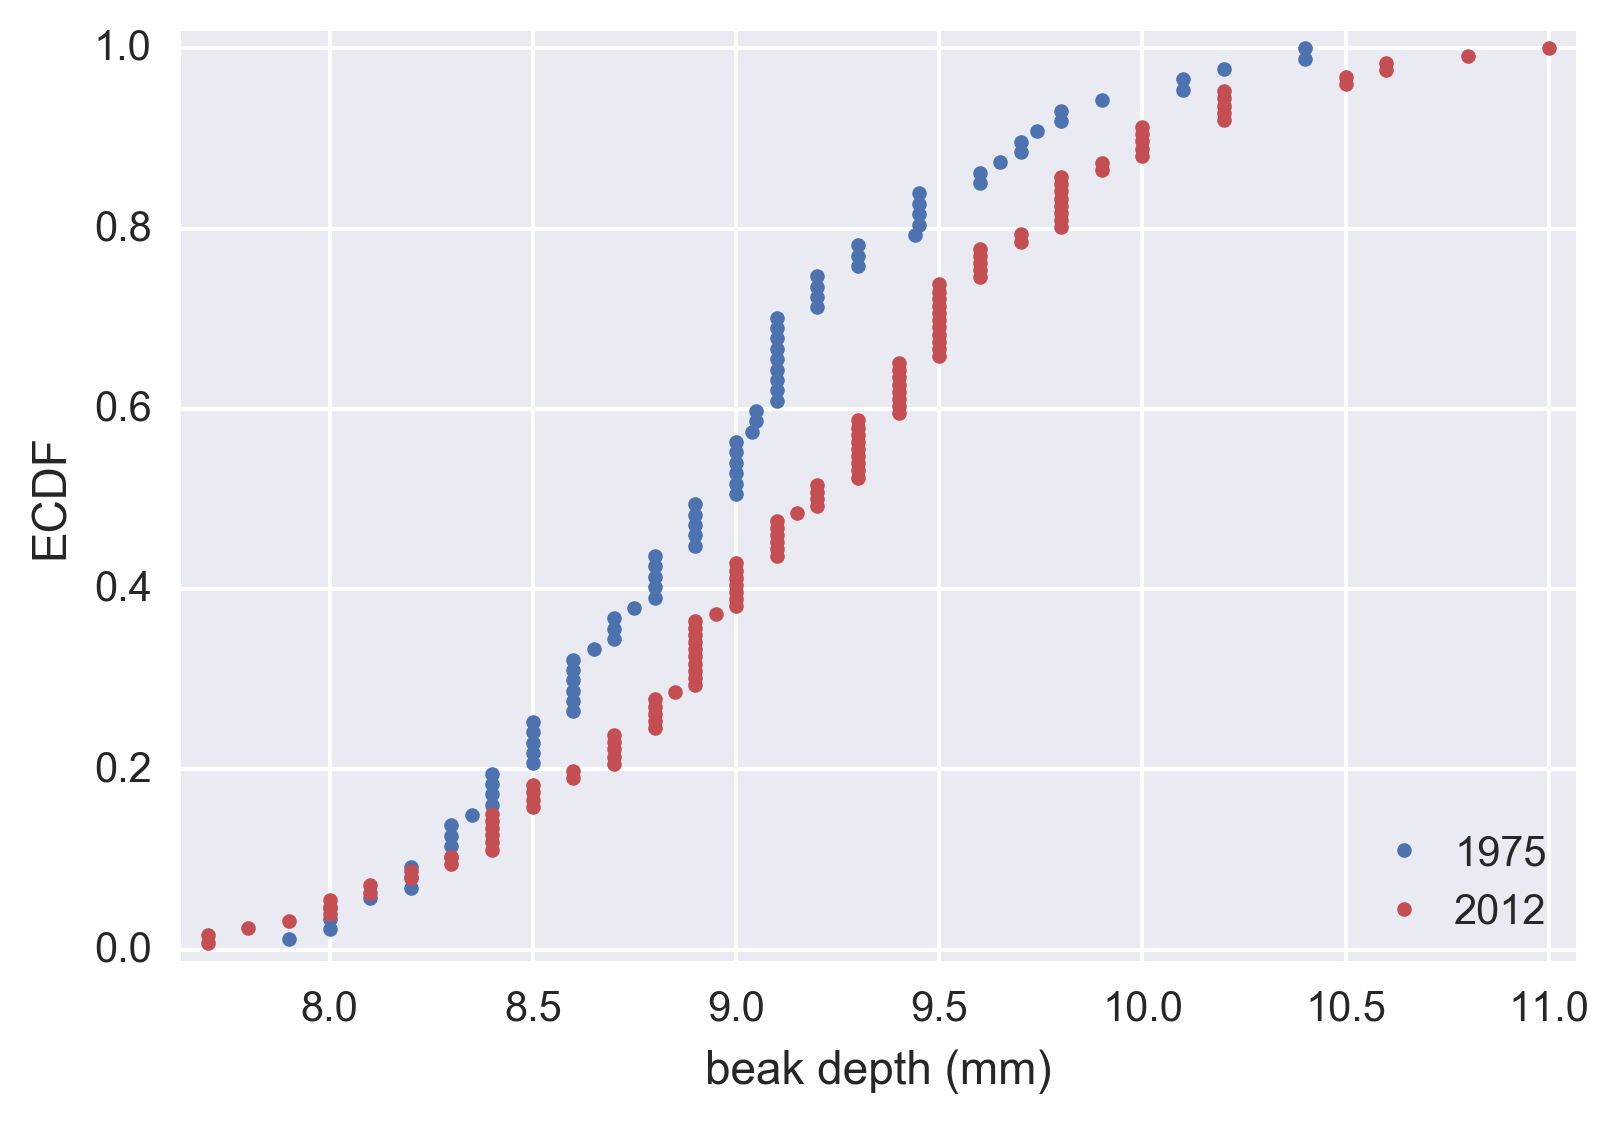

In [5]:
# Compute coordinates for ECDF
bd_1975 = df.loc[(df.year==1975) & (df.species=='scandens'), 
                 'beak depth (mm)'].values
bd_2012 = df.loc[(df.year==2012) & (df.species=='scandens'), 
                 'beak depth (mm)'].values
x_1975, y_1975 = bebi103.ecdf(bd_1975)
x_2012, y_2012 = bebi103.ecdf(bd_2012)

# Plot ECDFs
plt.plot(x_1975, y_1975, '.')
plt.plot(x_2012, y_2012, '.', color=sns.color_palette()[2])
plt.margins(0.02)
plt.xlabel('beak depth (mm)')
plt.ylabel('ECDF')
plt.legend(('1975', '2012'), loc='lower right');

There does seem to be a definite shift toward deeper beaks in 2012. This could be due to selective pressure to have deeper beaks to enable cracking of larger nuts.

Let's compute the mean beak depth with a confidence interval for each year. To do this, we will use nonparametric bootstrap, but first we'll do it with the standard error of the mean, computing the 95% confidence interval.

In [6]:
# Compute plug-in estimates of the means
mean_bd_1975 = np.mean(bd_1975)
mean_bd_2012 = np.mean(bd_2012)

# Compute SEMs
sem_bd_1975 = np.std(bd_1975) / np.sqrt(len(bd_1975))
sem_bd_2012 = np.std(bd_2012) / np.sqrt(len(bd_2012))

# Report results
print("""
beak depths 1975: {0:.2f} ± {1:.2f} mm
beak depths 2012: {2:.2f} ± {3:.2f} mm
""".format(mean_bd_1975, 1.96*sem_bd_1975, mean_bd_2012, 1.96*sem_bd_2012))


beak depths 1975: 8.96 ± 0.12 mm
beak depths 2012: 9.19 ± 0.12 mm



We see that the confidence intervals of the mean beak depths just barely overlap, suggesting that there is a real difference between these two.

Now, let's compute the confidence interval using the bootstrap. First, we'll write some function to do the bootstrap calculations.

In [7]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))


@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=10000):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out

Now we'll take 10,000 replicates of each to get our 95% confidence intervals.

In [8]:
# Draw reps
bd_reps_1975 = draw_bs_reps_mean(bd_1975)
bd_reps_2012 = draw_bs_reps_mean(bd_2012)

# Compute confidence intervals
conf_int_1975 = np.percentile(bd_reps_1975, [2.5, 97.5])
conf_int_2012 = np.percentile(bd_reps_2012, [2.5, 97.5])

# Print results
print("""
beak depths 1975: [{1:.2f}  {0:.2f}  {2:.2f}] mm
beak depths 2012: [{4:.2f}  {3:.2f}  {5:.2f}] mm
""".format(mean_bd_1975, *tuple(conf_int_1975), 
           mean_bd_2012, *tuple(conf_int_2012)))


beak depths 1975: [8.84  8.96  9.08] mm
beak depths 2012: [9.07  9.19  9.31] mm



Unsurprisingly, we get almost the same results. This is due to the central limit theorem: the probability distribution of the plug-in estimate for the mean of measurements is Gaussian distributed in the limit of a large number of measurements.

**c)** Now, we can perform a hypothesis test about the two data sets. We will test the null hypothesis that the two data sets have the same mean using a test statistic of the difference of means, that is the mean of 2012 minus that of 1975. A test statistic computed under the null hypothesis is considered to be more extreme if it is greater than what was observed. First, we'll compute the observed difference of means.

In [9]:
diff_mean = np.mean(bd_2012) - np.mean(bd_1975)
print('Observed difference in means:', diff_mean, ' mm')

Observed difference in means: 0.228492063492  mm


To simulate the hypothesis, we shift the data sets by adding a scalar such that they have the same mean.

In [10]:
# Shift the data sets to the same mean
pooled_mean = np.mean(np.concatenate((bd_1975, bd_2012)))
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + pooled_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + pooled_mean

We then compute bootstrap replicates of the difference of the means to compute the p-value.

In [11]:
@numba.jit(nopython=True)
def draw_bs_reps_diff_mean(x, y, size=10000):
    """
    Generate bootstrap replicates with difference of means
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x)) - np.mean(draw_bs_sample(y))
    return out

# Generate samples (100,000)
bs_reps = draw_bs_reps_diff_mean(bd_2012_shifted, bd_1975_shifted, size=100000)

# Compute p-value
p_val = np.sum(bs_reps >= diff_mean) / len(bs_reps)

print('p-value =', p_val)

p-value = 0.00344


We get a p-value of about 0.003, which further suggests that there is a difference in the mean beak length. Remember, though, that the effect size is what is more important. The mean beak length differs by about 0.22 mm, which seems substantial to me over the course of less than 40 years. The effect size relative to the standard deviation of the pooled data, the Cohen's d, is a useful metric as well.

In [12]:
@numba.jit(nopython=True)
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = x.mean() - y.mean()
    pooled_variance = (len(x) * np.var(x) + len(y) * np.var(y)) \
                            / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)

print("Cohen's d:", cohen_d(bd_2012, bd_1975))

Cohen's d: 0.36393701058809264


This is a reasonable effect size, which is really a distillation of what we saw by plotting the ECDFs.

**d)** In investigating beak shape, let us first take a look at how beak length and depth are related. We'll make a scatter plot of beak depth vs. beak length for *G. scandens* and *G. fortis* over time.

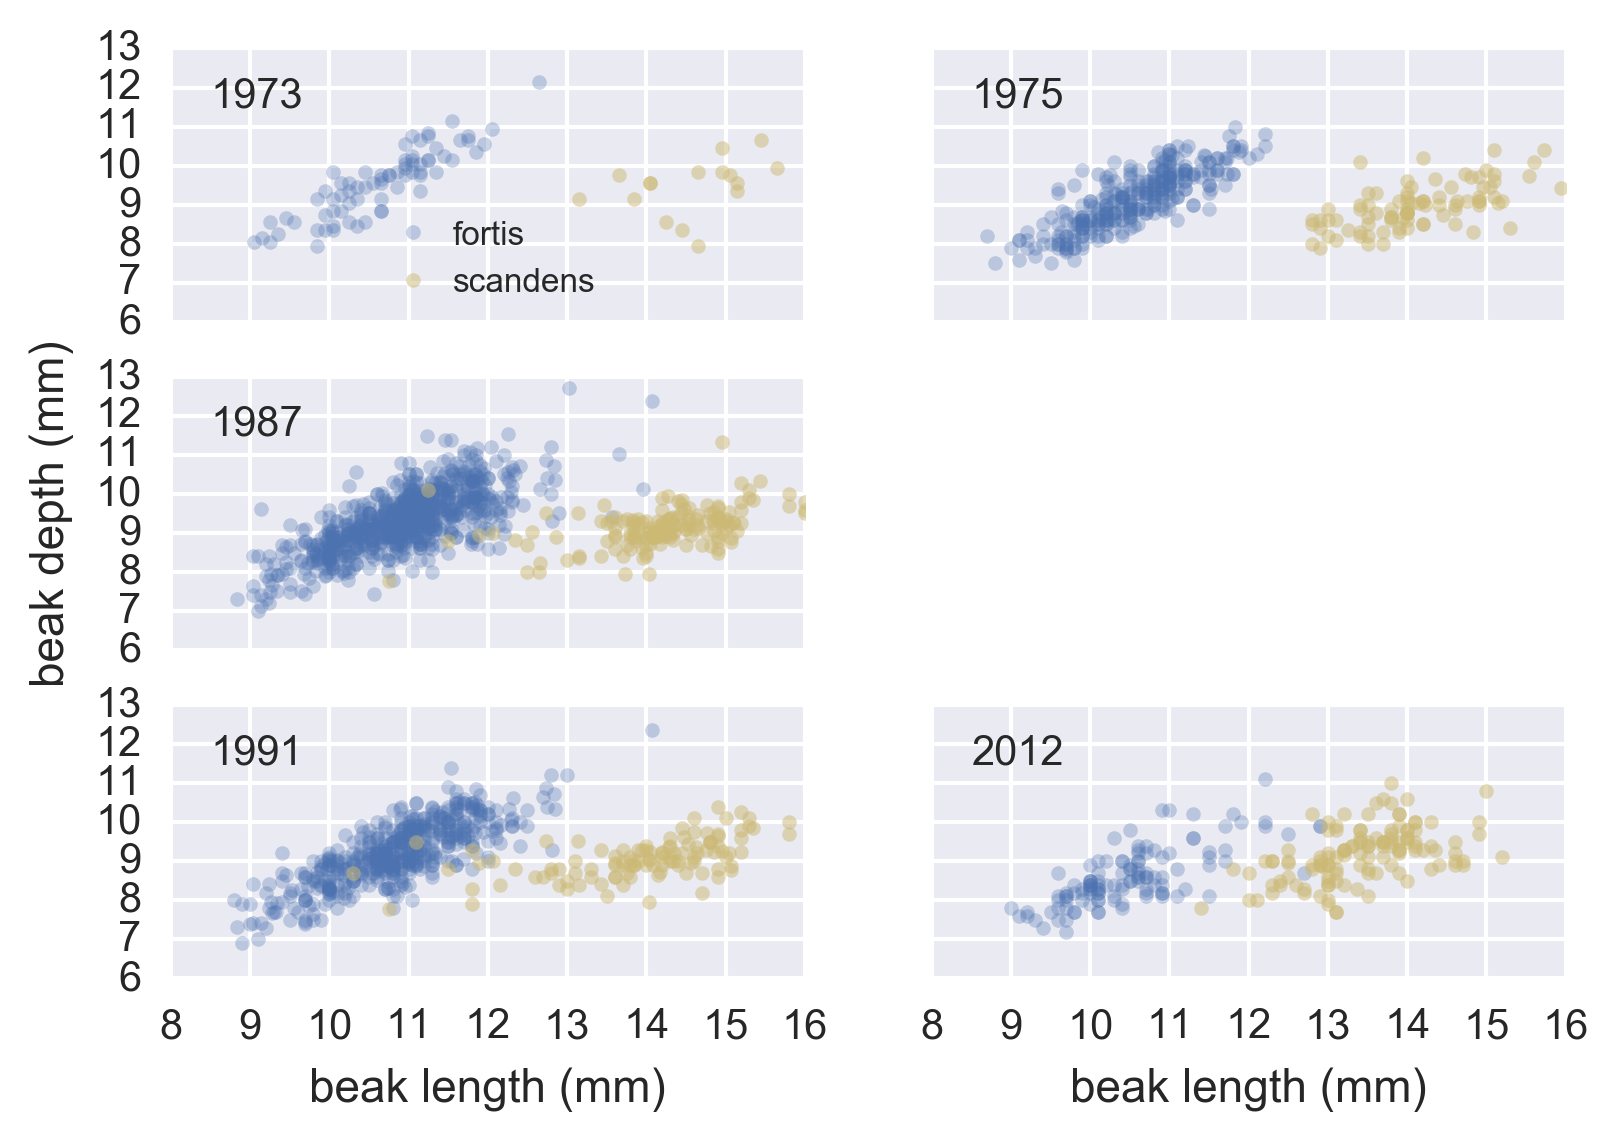

In [13]:
# Set up subplots
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)
sp_inds = [(0,0), (0,1), (1,0), (2,0), (2, 1)]
years = df.year.unique()

# Make plots
for i, year in enumerate(years):
    bd = df.loc[(df.year==year) & (df.species=='fortis'), 'beak depth (mm)']
    bl = df.loc[(df.year==year) & (df.species=='fortis'), 'beak length (mm)']
    ax[sp_inds[i]].plot(bl, bd, '.', color=sns.color_palette()[0], alpha=0.3)

    bd = df.loc[(df.year==year) & (df.species=='scandens'), 'beak depth (mm)']
    bl = df.loc[(df.year==year) & (df.species=='scandens'), 'beak length (mm)']
    ax[sp_inds[i]].plot(bl, bd, '.', color=sns.color_palette()[4], alpha=0.5)

    ax[sp_inds[i]].text(8.5, 11.5, str(year))
    
# Clear out unused axis
fig.delaxes(ax[1,1])

# Legened
ax[sp_inds[0]].legend(('fortis', 'scandens'), fontsize=8, loc='lower center')

# Axis labels
ax[1,0].set_ylabel('beak depth (mm)')
ax[-1,0].set_xlabel('beak length (mm)')
ax[-1,1].set_xlabel('beak length (mm)');

Here, we show *G. fortis* in blue and *G scandens* in gold. Over time, the beaks of the respective species seem to be getting more similar. The *G. scandens* beaks get a bit shorter and deeper, with *G. fortis* getting slightly shallower.

As a metric for beak shape, we can choose the ratio of depth to length. If the shape of the beak is constant, show should the ratio. I.e., if the beak length increases, but the depth-to-length ratio stays the same, the beak just got bigger; it did no change shape. So, let's look at ECDFs of the depth to length ratio.

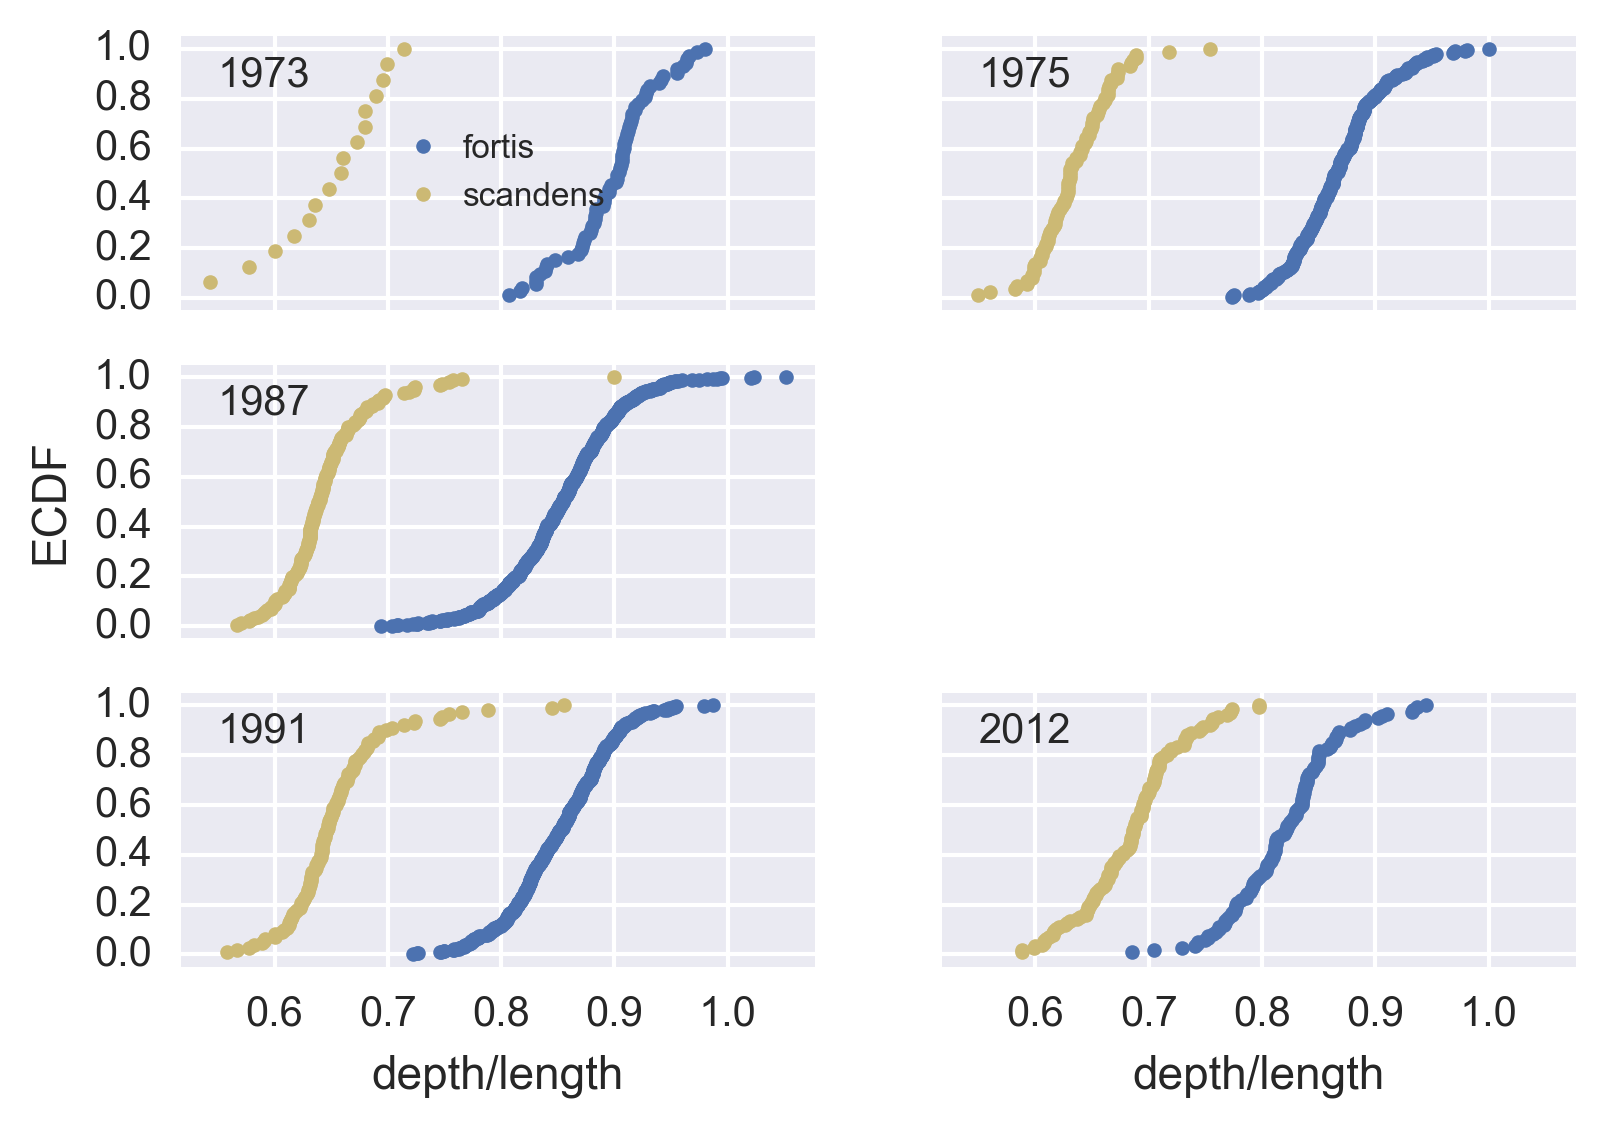

In [14]:
# Set up subplots
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)
sp_inds = [(0,0), (0,1), (1,0), (2,0), (2, 1)]
years = df.year.unique()

# Make plots
for i, year in enumerate(years):
    bd = df.loc[(df.year==year) & (df.species=='fortis'), 'beak depth (mm)']
    bl = df.loc[(df.year==year) & (df.species=='fortis'), 'beak length (mm)']
    x, y = bebi103.ecdf(bd/bl)
    ax[sp_inds[i]].plot(x, y, '.', color=sns.color_palette()[0])

    bd = df.loc[(df.year==year) & (df.species=='scandens'), 'beak depth (mm)']
    bl = df.loc[(df.year==year) & (df.species=='scandens'), 'beak length (mm)']
    x, y = bebi103.ecdf(bd/bl)
    ax[sp_inds[i]].plot(x, y, '.', color=sns.color_palette()[4])

    ax[sp_inds[i]].text(0.55, 0.85, str(year))
    
    ax[sp_inds[i]].margins(0.05)
    
# Clear out unused axis
fig.delaxes(ax[1,1])

# Legend
ax[sp_inds[0]].legend(('fortis', 'scandens'), fontsize=8, loc='center')

# Axis labels
ax[1,0].set_ylabel('ECDF')
ax[-1,0].set_xlabel('depth/length')
ax[-1,1].set_xlabel('depth/length');

Indeed, the ECDFs seem to be coming closer to each other. Let's compute the median length to depth ratio for each year, with a confidence interval, and plot them over time.

In [15]:
@numba.jit(nopython=True)
def draw_bs_reps_median(data, size=10000):
    """
    Draw boostrap replicates of the median from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.median(draw_bs_sample(data))
    return out

# Compute median and 95% conf int for each year, species
df_shape = pd.DataFrame(columns=['year', 'species', 'median', 
                                 'conf_low', 'conf_high'])

for year in years:
    for species in df.species.unique():
        # Extract ratios
        bd = df.loc[(df.year==year) & (df.species==species), 
                    'beak depth (mm)'].values
        bl = df.loc[(df.year==year) & (df.species==species), 
                    'beak length (mm)'].values
        dl_ratio = bd / bl

        # Compute bootstrap 95% confidence interval
        conf_int = np.percentile(draw_bs_reps_median(dl_ratio), 
                                      [2.5, 97.5])
        
        data_dict = {'year': year, 
                     'species': species,
                     'median': np.median(dl_ratio),
                     'conf_low': conf_int[0],
                     'conf_high': conf_int[1]}
        df_shape = df_shape.append(pd.DataFrame(data_dict, index=[0]), 
                                   ignore_index=True)

Now we can make a plot of the ratio of beak depths versus year.

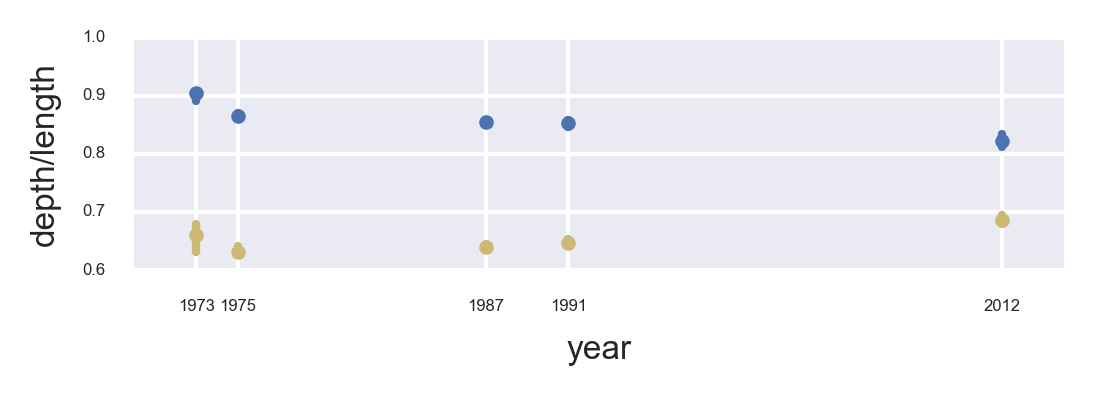

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1))
colors = {'fortis': sns.color_palette()[0], 'scandens': sns.color_palette()[4]}
for year in years:
    for species in ['fortis', 'scandens']:
        ind = (df_shape.year==year) & (df_shape.species==species)
        
        plt.plot(year, df_shape.loc[ind, 'median'], '.', color=colors[species])
        plt.plot([year, year], 
                 [df_shape.loc[ind, 'conf_low'].values, 
                  df_shape.loc[ind, 'conf_high'].values], 
                 '-', color=colors[species])

# Make plot pretty
plt.xlabel('year', fontsize=8)
plt.ylabel('depth/length', fontsize=8)
plt.xticks(years);
plt.yticks((0.6, 0.7, 0.8, 0.9, 1.0))
plt.tick_params(labelsize=4)

The median beak depths-to-length ratio of the two species is slowly coming together over time.

**e)** In our analysis of heritability, we first load in the data and appropriately rename columns.

In [17]:
# Load in DataFrames
df_herit_fortis = pd.read_csv('../data/fortis_beak_depth_heredity.csv',
                             comment='#')
df_herit_scandens = pd.read_csv('../data/scandens_beak_depth_heredity.csv',
                                comment='#')

# Compute mid parent for fortis
df_herit_fortis['mid_parent'] = (df_herit_fortis['Male BD'] 
                                 + df_herit_fortis['Female BD']) / 2

# Rename mid offspring
df_herit_fortis = df_herit_fortis.rename(columns={'Mid-offspr': 'mid_offspring'})

Now, we define a function to compute the heritability. As usual, I'll Numba it since we'll use it for bootstrap replicates later. For now, we'll just get plug-in estimates for the heritability of *G. fortis* and *G. scandens*.

In [18]:
@numba.jit(nopython=True)
def heritability(parent, offspring):
    """
    Heritability calculated from parent-offspring pairs.
    """
    return np.sum(
        (parent - np.mean(parent)) * (offspring - np.mean(offspring))) \
            / np.var(parent) / len(parent)

# Get plug-in estimates
herit_fortis = heritability(df_herit_fortis['mid_parent'].values,
                            df_herit_fortis['mid_offspring'].values)
herit_scandens = heritability(df_herit_scandens['mid_parent'].values,
                              df_herit_scandens['mid_offspring'].values)

Now, to compute the confidence intervals, we bootstrap the heritability using pairs bootstrap. We first write functions to do this.

In [19]:
@numba.jit(nopython=True)
def draw_bs_pairs(x, y):
    """
    Draw a pairs bootstrap sample.
    """
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)
    return x[bs_inds], y[bs_inds]


@numba.jit(nopython=True)
def draw_bs_pairs_reps_heritability(parent, offspring, size=10000):
    """
    Draw bootstrap pairs replicates of heritability.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = heritability(*draw_bs_pairs(parent, offspring))
    return out

With these in place, we can compute the confidence intervals.

In [20]:
# Compute confidence intervals
conf_int_fortis = np.percentile(draw_bs_pairs_reps_heritability(
    df_herit_fortis['mid_parent'].values, 
    df_herit_fortis['mid_offspring'].values), [2.5, 97.5])

conf_int_scandens = np.percentile(draw_bs_pairs_reps_heritability(
    df_herit_scandens['mid_parent'].values, 
    df_herit_scandens['mid_offspring'].values), [2.5, 97.5])

# Print results
print("""
fortis beak depth heritability:   [{1:.2f}  {0:.2f}  {2:.2f}]
scandens beak depth heritability: [{4:.2f}  {3:.2f}  {5:.2f}]
""".format(herit_fortis,   *tuple(conf_int_fortis),
           herit_scandens, *tuple(conf_int_scandens)))


fortis beak depth heritability:   [0.65  0.72  0.80]
scandens beak depth heritability: [0.35  0.55  0.75]



There is some overlap in the confidence intervals of the heritability. We could do a test of the hypothesis that there is not difference between the two species. This involves a permutation test with a test statistic being the difference between the heritabilities. To compute a permutation replicate, we do the following.
1. Make a concatenated array of the $n$ *fortis* and $m$ *scandens* offspring beak depth. Do the same for the parents.
2. Each bird has an index. So, we make an array of indices for *fortis* birds and an array of indices for *scandens* birds.
3. Permute the indices such that the first $n$ indices are labeled "fortis" and the last $m$ indices are labeled "scandens."
4. Compute the test statistic.

In [21]:
@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]


@numba.jit(nopython=True)
def draw_perm_reps_diff_herit(parent_1, offspring_1, parent_2, offspring_2,
                              size=10000):
    """
    Generate array of permuation replicates.
    """
    # Concatenated arrays of parents and offspring
    parents = np.concatenate((parent_1, parent_2))
    offspring = np.concatenate((offspring_1, offspring_2))
    
    # Arrays of indices to mash up
    inds_1 = np.arange(len(parent_1))
    inds_2 = np.arange(len(parent_1), len(parent_1) + len(parent_2))
    
    # Compute replicates
    out = np.empty(size)
    for i in range(size):
        i1, i2 = draw_perm_sample(inds_1, inds_2)        
        out[i] = heritability(parents[i1], offspring[i1]) \
                    - heritability(parents[i2], offspring[i2])
    return out

Now, we'll compute our permutation replicates and then the p-value.

In [22]:
perm_reps = draw_perm_reps_diff_herit(df_herit_fortis['mid_parent'].values, 
                                      df_herit_fortis['mid_offspring'].values,
                                      df_herit_scandens['mid_parent'].values, 
                                      df_herit_scandens['mid_offspring'].values,
                                      size=100000)

p_val = (perm_reps > herit_fortis - herit_scandens).sum() / len(perm_reps)

print("p-value =", p_val)

p-value = 0.02028


We get a p-value of 0.02, which is not all that small. I would be hesitant to say there is a significant difference (though we may say there is a "*statistically significant*" difference).

**f)** 